In [1]:
# 1-------------------------------
# Import necessary libraries
# -------------------------------
import os
import json
import random
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import DataLoader, Subset
from torchvision import transforms
from torchvision.models.detection.faster_rcnn import FasterRCNN
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
from torchvision.ops import box_iou
from PIL import Image

# -------------------------------
# Set device (Kaggle P100 GPU)
# -------------------------------
print("CUDA Available:", torch.cuda.is_available())
print("GPU Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU detected")
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print("Using device:", device)

CUDA Available: True
GPU Name: NVIDIA GeForce RTX 3080
Using device: cuda


In [2]:
# 2-------------------------------
# Custom Dataset Class (using COCO annotations)
# -------------------------------

def load_yolo_annotations(yolo_label_path, img_width, img_height):
    """
    Load YOLO-format annotations with pose information from a text file.
    
    Each line in the file has 6 values:
      - class: (ignored, because we are forcing a single "person" label)
      - x_center: normalized center x-coordinate of the bounding box
      - y_center: normalized center y-coordinate of the bounding box
      - width: normalized width of the bounding box
      - height: normalized height of the bounding box
      - pose: pose information (ignored in this version since we force the label to 1)
      
    The normalized coordinates are multiplied by the image width/height
    to convert them into absolute pixel values.
    
    The YOLO format defines bounding boxes with a center and dimensions.
    This function converts that format to the [x_min, y_min, x_max, y_max] format 
    required by Faster R-CNN.
    
    Returns:
       - boxes: a tensor of shape (N, 4) containing bounding boxes in absolute pixel coordinates.
       - labels: a tensor of shape (N,) containing the forced label (1) for "person".
    """
    
    # Check if the annotation file exists; if not, list available files for debugging.
    if not os.path.exists(yolo_label_path):
        available = os.listdir(os.path.dirname(yolo_label_path))
        raise FileNotFoundError(f"File not found: {yolo_label_path}\nAvailable files: {available}")

    boxes = []   # List to hold bounding box coordinates
    labels = []  # List to hold labels for each bounding box
    with open(yolo_label_path, 'r') as f:
        # Read each line in the YOLO annotation file.
        for line in f.readlines():
            # Split the line into separate values (as strings)
            values = line.strip().split()
            # Ensure that there are at least 6 values; if not, skip this line.
            if len(values) < 6:
                continue  # Skip invalid lines

            # Convert the relevant values from string to float:
            # Skip the first value (class) because we force the label later.
            # Extract normalized values
            x_center_norm, y_center_norm, width_norm, height_norm = map(float, values[1:5])

            # Convert normalized coordinates to absolute pixel values
            x_center = x_center_norm * img_width
            y_center = y_center_norm * img_height
            width_abs = width_norm * img_width
            height_abs = height_norm * img_height
            
            # Convert YOLO bounding box format (center, width, height) to
            # [x_min, y_min, x_max, y_max] format.
            # Convert YOLO bbox (center, width, height) to [x_min, y_min, x_max, y_max]
            x_min = x_center - (width_abs / 2)
            y_min = y_center - (height_abs / 2)
            x_max = x_center + (width_abs / 2)
            y_max = y_center + (height_abs / 2)

            # Append the converted bounding box to the list.
            boxes.append([x_min, y_min, x_max, y_max])

            # Assign label 1 for "person" (single-class human detection)
            person_label = 1
            labels.append(person_label)

    # Convert the lists of boxes and labels into torch tensors.
    return torch.tensor(boxes, dtype=torch.float32), torch.tensor(labels, dtype=torch.int64)

class C2ACocoDataset(Dataset):
    def __init__(self, root_dir, split='train', transform=None):
        """
        Args:
            root_dir (str): Path to the new_dataset3 directory.
            split (str): 'train', 'val', or 'test'.
            transform (callable, optional): Transformations to apply to the images.
        """
        self.root_dir = root_dir  # Root directory of the dataset
        self.split = split  # Dataset split (train/val/test)
        self.transform = transform  # Image transformations (e.g., normalization)

        # Image directory and COCO annotation JSON for the given split.
        # Define the image directory based on the split.
        self.img_dir = os.path.join(root_dir, split, "images")
        # Define the path to the COCO annotation JSON file for this split.
        self.ann_path = os.path.join(root_dir, split, f"{split}_annotations.json")

        # Load COCO JSON annotations.
        with open(self.ann_path, 'r') as f:
            self.coco_data = json.load(f)

        # Build mapping from image id to image info. (e.g., dimensions, filename).
        self.imgs = {img_info['id']: img_info for img_info in self.coco_data['images']}
        # Create a list of image IDs for indexing.
        self.ids = list(self.imgs.keys())

        # Define the folder that contains the YOLO-format labels with pose information.
        # This folder is inside the "All labels with Pose information" folder.
        self.pose_labels_dir = os.path.join(root_dir, "All labels with Pose information", "labels")

    def __len__(self):
        # Return the number of images in the dataset.
        return len(self.ids)

    def __getitem__(self, idx):
        """
        Retrieve a single image and its annotations.
        """
        # Retrieve image info.
        # Get the image ID from the list of IDs.
        img_id = self.ids[idx]
        # Retrieve the image information (dimensions, filename, etc.) using the image ID.
        img_info = self.imgs[img_id]
        # Extract the filename of the image.
        img_filename = img_info['file_name']
        # Build the full path to the image file.
        img_path = os.path.join(self.img_dir, img_filename)

        # Open the image using PIL and convert it to RGB format.
        image = Image.open(img_path).convert("RGB")
        # Apply transformations (e.g., ToTensor, normalization) if provided.
        if self.transform:
            image = self.transform(image)

        # Get image dimensions from COCO JSON.
        img_width = img_info['width']
        img_height = img_info['height']

        # Construct the path to the corresponding YOLO-format label file.
        # The label file has the same base filename as the image, but with a .txt extension.
        pose_label_path = os.path.join(self.pose_labels_dir, os.path.splitext(img_filename)[0] + ".txt")

        # Load YOLO annotations (with pose info) and convert to absolute coordinates.
        boxes, labels = load_yolo_annotations(pose_label_path, img_width, img_height)

        # Build the target dictionary expected by the detection model.
        target = {
            "boxes": boxes,             # Bounding boxes in [x_min, y_min, x_max, y_max] format.
            "labels": labels,           # Labels for each bounding box (forced to 1 for person).
            "image_id": torch.tensor([img_id])  # Unique image identifier.
        }
        return image, target

In [ ]:
# 3-------------------------------
# Define image transforms: conversion to tensor and ImageNet normalization
# -------------------------------

# Compose a series of transformations to apply to each image:
# 1. Convert the image to a PyTorch tensor.
# 2. Normalize the image using the ImageNet mean and standard deviation.
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert PIL image (or numpy array) to a torch.Tensor and scale pixel values to [0, 1]
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Normalize with ImageNet mean values
                         std=[0.229, 0.224, 0.225])   # Normalize with ImageNet standard deviation values
])

# -------------------------------
# Set dataset root directory (update as needed in Kaggle)
# -------------------------------
dataset_root = './C2A_Dataset/new_dataset3'

# Create training and validation datasets and dataloaders.
from torch.utils.data import DataLoader

# This instance will load images and annotations from the 'train' split.
train_dataset = C2ACocoDataset(root_dir=dataset_root, split='train', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
# train_subset = Subset(train_dataset, list(range(3000)))
# Create a DataLoader for the training subset with a batch size of 2, shuffling enabled,
# and a custom collate function that groups data samples into tuples.
# train_loader = DataLoader(train_subset, batch_size=2, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

# This instance will load images and annotations from the 'val' split.
val_dataset = C2ACocoDataset(root_dir=dataset_root, split='val', transform=transform)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))
# val_subset = Subset(val_dataset, list(range(1000)))
# Create a DataLoader for the validation subset with a batch size of 1 (for easier evaluation)
# and no shuffling since order is not important during evaluation.
# val_loader = DataLoader(val_subset, batch_size=1, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

# test subset if you're also using test set
test_dataset = C2ACocoDataset(root_dir=dataset_root, split='test', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
# test_subset = Subset(test_dataset, list(range(1000)))
# Create a DataLoader for the test subset with a batch size of 1 and no shuffling.
# test_loader = DataLoader(test_subset, batch_size=1, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

# -------------------------------
# Test the dataset loading by printing one sample's target
# -------------------------------
# Create an instance of the training dataset to test data loading.
dataset = C2ACocoDataset(root_dir=dataset_root, split="train", transform=transform)
# Retrieve the first sample (both image and its corresponding target annotations).
image, target = dataset[0]
# Print the target annotations to verify that the bounding boxes, labels, and image ID are loaded correctly.
print("Sample target:", target)

Sample target: {'boxes': tensor([[603.0001, 142.0000, 607.0001, 146.9999],
        [399.0004, 281.0002, 408.0002, 293.0002],
        [504.0002, 204.9997, 523.0004, 224.9998],
        [580.0000, 213.9999, 587.9999, 231.9997],
        [579.9997, 387.0002, 598.9999, 397.0000],
        [ 45.9999,  63.0002,  62.0002,  77.0000],
        [435.9998, 275.0001, 452.0001, 288.0001],
        [249.0000,  49.0001, 252.9999,  54.0000],
        [581.9997, 517.9998, 596.9999, 526.9997],
        [483.0003, 103.9998, 491.0002, 115.9999],
        [353.0002, 244.0003, 361.0000, 254.0001],
        [ 45.0002, 329.9998,  50.0001, 345.0000],
        [ 54.9997, 401.0001,  82.9997, 418.9999],
        [125.0003, 125.9999, 134.0001, 135.9997],
        [318.0003, 310.9998, 320.0003, 313.9999],
        [388.9997,  64.0001, 412.9998,  69.9999],
        [296.9998,  41.9997, 316.0001,  56.9999],
        [570.0002,  50.0000, 577.0001,  66.0001],
        [ 80.0001, 430.0001,  82.0000, 433.0002],
        [582.9999, 148.99

In [4]:
# 4-------------------------------
# Model Setup: Create Faster R-CNN with custom backbone.
# 

# import torch
# import torch.nn as nn
# from collections import OrderedDict
# from torchvision.models.detection import FasterRCNN
# from torchvision.models.detection.rpn import AnchorGenerator

# # -------------------------------
# # Custom CNN Backbone for Faster R-CNN
# # -------------------------------
# class CustomCNNBackbone(nn.Module):
#     def __init__(self):
#         super(CustomCNNBackbone, self).__init__()
#         # Custom CNN backbone with 3 convolutional blocks
#         self.features = nn.Sequential(
#             # Block 1: Convolution, ReLU, and MaxPool
#             nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),  # Convolution: 3→32 channels, preserves size
#             nn.ReLU(inplace=True),                                 # Activation: ReLU
#             nn.MaxPool2d(kernel_size=2, stride=2),                   # Pooling: Downsample by factor 2

#             # Block 2: Increase depth from 32 to 64 channels
#             nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2, stride=2),                   # Downsample by factor 2

#             # Block 3: Increase depth from 64 to 128 channels with dropout
#             nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Dropout(0.25),                                      # Dropout to help prevent overfitting
#             nn.MaxPool2d(kernel_size=2, stride=2)                   # Final downsampling
#         )
        
#     def forward(self, x):
#         features = self.features(x)  # Pass the input through the custom CNN
#         # Return feature map wrapped in an OrderedDict with key "0" (one-level output for the RPN)
#         return OrderedDict([("0", features)])

# # Instantiate the custom backbone.
# custom_backbone = CustomCNNBackbone()
# # Set the out_channels attribute (output channels from the backbone)
# custom_backbone.out_channels = 128

# # -------------------------------
# # Custom Anchor Generator with Adjusted Sizes
# # -------------------------------
# # Since our backbone returns one feature map, we set sizes appropriate for that resolution.
# # Using a smaller anchor size (16 instead of 32) might better suit the resolution.
# anchor_generator = AnchorGenerator(
#     sizes=((16,),),  # Single feature map: anchors of size 16 pixels.
#     aspect_ratios=((0.5, 1.0, 2.0),)  # Common aspect ratios for objects.
# )

# # -------------------------------
# # Create Faster R-CNN Model using the Custom Backbone and Anchor Generator
# # -------------------------------
# # Set num_classes to 6 (e.g., background + 5 pose classes) or adjust as needed.
# model = FasterRCNN(custom_backbone, num_classes=6, rpn_anchor_generator=anchor_generator)

# # -------------------------------
# # Custom Box Predictor with Extra Dropout (for the ROI head)
# # -------------------------------
# class FastRCNNPredictorWithDropout(nn.Module):
#     def __init__(self, in_channels, num_classes, dropout_prob=0.5):
#         """
#         A custom ROI head predictor that adds a dropout layer before the fully-connected layers.
#         It outputs classification scores and bounding box regressions.
#         """
#         super(FastRCNNPredictorWithDropout, self).__init__()
#         self.dropout = nn.Dropout(dropout_prob)                   # Dropout for regularization.
#         self.cls_score = nn.Linear(in_channels, num_classes)       # Fully-connected layer for classification.
#         self.bbox_pred = nn.Linear(in_channels, num_classes * 4)    # FC layer for bounding box regression (4 values per class).
    
#     def forward(self, x):
#         x = x.flatten(start_dim=1)    # Flatten the ROI feature tensor into a vector.
#         x = self.dropout(x)           # Apply dropout.
#         scores = self.cls_score(x)    # Compute class scores.
#         bbox_deltas = self.bbox_pred(x)  # Compute bounding box adjustments.
#         return scores, bbox_deltas

# # Replace the default box predictor in the ROI head with the custom one.
# in_features = model.roi_heads.box_predictor.cls_score.in_features
# model.roi_heads.box_predictor = FastRCNNPredictorWithDropout(in_features, num_classes=6, dropout_prob=0.5)

# # Move the model to the designated device (GPU or CPU).
# model.to(device)

from collections import OrderedDict
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

# -------------------------------
# Upgraded Custom CNN Backbone for Faster R-CNN
# -------------------------------
class UpgradedCustomCNNBackbone(nn.Module):
    def __init__(self):
        super(UpgradedCustomCNNBackbone, self).__init__()
        # Block 1: Low-level feature extraction from the input RGB image. 
        # Block 1 (Lines 10-15):

        #     nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        #     A 2D convolutional layer that converts a 3-channel input into 64 feature maps using a 3×3 kernel, with a stride of 1 (moving one pixel at a time) and padding of 1 (which preserves the spatial dimensions).
            
        #     nn.BatchNorm2d(64)
        #     A batch normalization layer normalizes the outputs, stabilizing and speeding up training.
            
        #     nn.ReLU(inplace=True)
        #     The ReLU (Rectified Linear Unit) activation function introduces non-linearity, which is essential for learning complex patterns.
            
        #     nn.MaxPool2d(kernel_size=2, stride=2)
        #     Max pooling downsamples the feature maps by taking the maximum value in a 2×2 window, reducing spatial dimensions by a factor of 2.
        self.block1 = nn.Sequential(
            # Convolution layer:
            # Takes a 3-channel (RGB) input and applies 64 filters of size 3x3,
            # stride 1, and padding 1 ensures the output spatial size is the same as input.
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            # Batch Normalization helps stabilize and accelerate training by normalizing activations.
            nn.BatchNorm2d(64),
            # ReLU activation introduces non-linearity, allowing the network to learn complex features.
            nn.ReLU(inplace=True),
            # Max Pooling downsamples the feature map by a factor of 2 (kernel size 2, stride 2),
            # thereby reducing computational complexity and providing some translation invariance.
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        # Block 2: Increases the depth and extracts more complex features.
        # Similar to Block 1, but increases feature depth from 64 to 128. Includes two convolution layers, batch normalization, ReLU activation, and max pooling.
        self.block2 = nn.Sequential(
            # Convolution layer increases feature map depth from 64 to 128 channels.
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            # A second convolution in the block for additional feature extraction.
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            # Downsample via Max Pooling.
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        # Block 3: Further increases representational power and extracts mid-level features.
        # Increases depth further from 128 to 256. Two consecutive convolution layers help to learn more complex features. Max pooling again downsamples.
        self.block3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            # Downsampling via Max Pooling.
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        # Block 4: High-level feature extraction, which helps in detecting complex object parts.
        # A higher-level feature extraction block that increases depth from 256 to 512. Includes a dropout layer (nn.Dropout(0.3)) to mitigate overfitting.
        self.block4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            # Additional dropout layer to reduce overfitting by randomly zeroing activations.
            nn.Dropout(0.3),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Combine all blocks sequentially.
        # All blocks are combined into a single sequential module self.features. In the forward() method, the input image goes through these blocks to produce a feature map. The feature map is returned as an OrderedDict with a single key "0", which is the format expected by Faster R-CNN.
        self.features = nn.Sequential(
            self.block1,
            self.block2,
            self.block3,
            self.block4
        )
        
    def forward(self, x):
        # Pass the input through the feature extractor (the entire sequential layers).
        features = self.features(x)
        # Faster R-CNN requires the backbone to return an OrderedDict
        # with feature maps keyed by their scale. Since our backbone produces a single feature map,
        # we return it with the key "0".
        return OrderedDict([("0", features)])

# Instantiate the upgraded custom backbone.
upgraded_backbone = UpgradedCustomCNNBackbone()
# Set the output channels of the backbone.
# The last block outputs 512 channels, which is crucial for the region proposal network (RPN).
upgraded_backbone.out_channels = 512

# -------------------------------
# Custom Anchor Generator
# -------------------------------
# The anchor generator creates a set of default boxes (anchors) for each location on the feature map.
# These anchors are later matched with ground truth boxes.
# Here, we set the anchor size to 64, which is more appropriate given the deeper features produced.
anchor_generator = AnchorGenerator(
    sizes=((64,),),  # A single feature map output: anchors of size 64 pixels.
    aspect_ratios=((0.5, 1.0, 2.0),)  # Common aspect ratios that help detect objects of varying shapes.
)

# -------------------------------
# Create Faster R-CNN Model using the Upgraded Custom Backbone
# -------------------------------
# Instantiate the Faster R-CNN detection model using our custom backbone and the custom anchor generator.
# 'num_classes' is set to 6. This should typically be: 1 (background) + number of target classes.
# Adjust this value depending on the classification scheme (e.g., background and human pose classes).
model = FasterRCNN(upgraded_backbone, num_classes=6, rpn_anchor_generator=anchor_generator)

# -------------------------------
# Custom ROI Head Predictor with Extra Dropout
# -------------------------------
class FastRCNNPredictorWithDropout(nn.Module):
    def __init__(self, in_channels, num_classes, dropout_prob=0.5):
        """
        Custom predictor for the ROI head that applies dropout before the fully-connected layers.
        It outputs class scores and bounding box regression adjustments.
        Args:
            in_channels (int): Number of input features from the ROI head.
            num_classes (int): Number of classes (including background).
            dropout_prob (float): Dropout probability.
        """
        super(FastRCNNPredictorWithDropout, self).__init__()
        # Dropout layer helps to prevent overfitting by randomly zeroing some inputs.
        self.dropout = nn.Dropout(dropout_prob)
        # Fully-connected layer for producing class scores.
        self.cls_score = nn.Linear(in_channels, num_classes)
        # Fully-connected layer for predicting bounding box adjustments.
        # It outputs 4 values per class (x_min, y_min, x_max, y_max adjustments).
        self.bbox_pred = nn.Linear(in_channels, num_classes * 4)
    
    def forward(self, x):
        # Flatten the feature tensor (from the ROI pooling layer) into a vector.
        x = x.flatten(start_dim=1)
        # Apply dropout for regularization.
        x = self.dropout(x)
        # Compute the class scores.
        scores = self.cls_score(x)
        # Compute bounding box regression deltas.
        bbox_deltas = self.bbox_pred(x)
        return scores, bbox_deltas

# Get the number of input features for the original box predictor (needed for replacing it).
in_features = model.roi_heads.box_predictor.cls_score.in_features
# Replace the default ROI head box predictor with our custom predictor that includes dropout.
model.roi_heads.box_predictor = FastRCNNPredictorWithDropout(in_features, num_classes=6, dropout_prob=0.5)

# -------------------------------
# Move the Model to Device
# -------------------------------
# Move the entire model to the appropriate device (GPU if available, otherwise CPU).
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): UpgradedCustomCNNBackbone(
    (block1): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (block2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): MaxPool2d(kernel

In [5]:
# 5-------------------------------
# Training Loop
# -------------------------------

# Set up optimizer, LR scheduler, and early stopping parameters

# Set up the optimizer: using SGD with momentum and weight decay for regularization.
optimizer = optim.SGD(model.parameters(), lr=0.002, momentum=0.9, weight_decay=0.0005)
# Set up the learning rate scheduler:
# This scheduler reduces the learning rate when the validation loss plateaus.
# lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=1)
# Learning rate scheduler: Step decay instead of ReduceLROnPlateau
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)
# Define the maximum number of training epochs.
num_epochs = 10  # Maximum epochs
# Initialize the best validation loss to a very high value for comparison.
best_val_loss = float('inf')
# Set the patience for early stopping (number of epochs with no improvement before stopping).
patience = 2
epochs_no_improve = 0

# Define a function to compute the validation loss.
# The model must be in training mode to return a loss dictionary.
def compute_val_loss(model, data_loader, device):
    model.train()  # Switch model to training mode so that it returns losses.
    total_loss = 0.0  # Initialize total loss accumulator.
    count = 0       # Count the number of batches.
    with torch.no_grad():  # Disable gradient computation for evaluation.
        for images, targets in data_loader:
            # Move images and targets to the designated device (GPU/CPU).
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            
            # Forward pass: obtain the loss dictionary from the model.
            loss_dict = model(images, targets)
            
            # Verify that loss_dict is indeed a dictionary and sum its values.
            if isinstance(loss_dict, dict):
                loss = sum(loss for loss in loss_dict.values())
            else:
                raise TypeError("Expected loss_dict to be a dictionary.")
            
            # Accumulate the loss and increment the batch counter.
            total_loss += loss.item()
            count += 1
    model.eval()  # Switch back to evaluation mode.
    # Return the average loss over the batches.
    return total_loss / count if count > 0 else 0

# Training loop (losses are hidden during training)
model.train()

# Loop over the number of epochs.
for epoch in range(num_epochs):
    # Iterate through each batch in the training DataLoader.
    for images, targets in train_loader:
        # Move images to the specified device.
        images = [img.to(device) for img in images]
        # Move all target tensors to the device.
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        model.train()  # Ensure the model is in training mode to compute losses.
        # Forward pass: compute the losses from the model for this batch.
        loss_dict = model(images, targets)
        
        # Ensure that the loss is in the expected dictionary format.
        if isinstance(loss_dict, dict):
            losses = sum(loss for loss in loss_dict.values())
        else:
            raise TypeError("Expected loss_dict to be a dictionary.")

        # Check for NaN losses and skip gradient update if necessary
        if torch.isnan(losses):
            print("Warning: NaN loss detected, skipping this batch!")
            continue  # Skip this batch to prevent model corruption
        
        # Zero out the gradients from the previous iteration.
        optimizer.zero_grad()
        # Backward pass: compute the gradients.
        losses.backward()
        # Gradient Clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=10.0)
        # Update the model's weights.
        optimizer.step()
    
    # After processing all batches in the current epoch, compute the validation loss.
    val_loss = compute_val_loss(model, val_loader, device)
    
    # Update the learning rate scheduler based on the validation loss.
    lr_scheduler.step(val_loss)
    
    # Print the validation loss for this epoch.
    print(f"Epoch {epoch+1}, Validation Loss: {val_loss:.4f}")
    
    # Early stopping check:
    # If the validation loss has improved, reset the counter; otherwise, increment it.
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        # If no improvement has occurred for 'patience' epochs, stop training.
        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1, Validation Loss: 1.2341
Epoch 2, Validation Loss: 1.1016
Epoch 3, Validation Loss: 1.1013
Epoch 4, Validation Loss: 1.0063
Epoch 5, Validation Loss: 0.9654
Epoch 6, Validation Loss: 0.9473
Epoch 7, Validation Loss: 0.9381
Epoch 8, Validation Loss: 0.9309
Epoch 9, Validation Loss: 0.9236
Epoch 10, Validation Loss: 0.8843


In [6]:
# 6-------------------------------
# Evaluation Function
# -------------------------------
def evaluate_model(model, data_loader, device, iou_threshold=0.5, score_threshold=0.1):
    """
    Evaluate the detection model using several metrics.
    
    This function calculates:
    - Precision: Proportion of predicted boxes that are correct.
    - Recall: Proportion of ground truth boxes that were detected.
    - F1 Score: Harmonic mean of precision and recall.
    - Average IoU: Average Intersection over Union of matched predictions.
    - mAP: Mean Average Precision over multiple IoU thresholds (0.5 to 0.95).
    - mAP@0.50: Average Precision at a fixed IoU threshold of 0.50.
    
    By default, the score_threshold is lowered to 0.1 to allow more low-confidence boxes to be considered,
    which can help if the custom model produces lower scores than expected.
    
    Args:
        model: The detection model.
        data_loader: DataLoader for the dataset to evaluate.
        device: The device (GPU/CPU) to run evaluation on.
        iou_threshold: The IoU threshold for considering a prediction as a true positive.
        score_threshold: The score threshold for filtering predictions.
    
    Returns:
        Tuple with (precision, recall, f1_score, avg_iou, mAP, mAP_50)
    """
    model.eval()  # Set model to evaluation mode (disables dropout and updates batch norm stats)
    
    # Initialize accumulators for overall true positives, false positives, false negatives, and IoU.
    total_tp, total_fp, total_fn = 0, 0, 0
    total_iou = 0.0
    matched_boxes = 0  # Count of matched bounding boxes (true positives)
    
    # List to store the computed AP (Average Precision) for a range of IoU thresholds.
    aps = []
    # Define IoU thresholds ranging from 0.5 to 0.95 (in 0.05 increments)
    iou_thresholds = [0.5 + i * 0.05 for i in range(10)]
    
    # Disable gradient computations since we are evaluating.
    with torch.no_grad():
        # Loop over the data loader (assuming each batch contains one image)
        for images, targets in data_loader:
            # Move the image to the device.
            image = images[0].to(device)
            # Move target annotations (e.g., bounding boxes and labels) to the device.
            target = {k: v.to(device) for k, v in targets[0].items()}
            
            # Run a forward pass on the model for the given image.
            # During inference, we only pass the image (without target) to obtain predictions.
            outputs = model([image])[0]
            
            # Filter predictions using the score threshold.
            # Lowering score_threshold from 0.5 (default) to 0.1 allows more predictions to be considered.
            pred_boxes = outputs['boxes'][outputs['scores'] > score_threshold]
            # Ground truth bounding boxes for the image.
            gt_boxes = target['boxes']
            
            # If no predictions pass the threshold, treat all ground truth boxes as false negatives.
            if len(pred_boxes) == 0:
                total_fn += len(gt_boxes)
                continue
            
            # Compute Intersection-over-Union (IoU) between each predicted box and the ground truth boxes.
            ious = box_iou(pred_boxes, gt_boxes)
            used_gt = set()  # To mark which ground truth boxes have already been matched
            
            # Iterate over each predicted bounding box.
            for i in range(len(pred_boxes)):
                # If no ground truth boxes exist, skip.
                if ious.shape[1] == 0:
                    continue
                # For the i-th prediction, get the maximum IoU value and the corresponding ground truth index.
                max_iou, max_idx = ious[i].max(0)
                # Check if the maximum IoU meets the specified iou_threshold and that the matching gt hasn't been used.
                if max_iou >= iou_threshold and max_idx.item() not in used_gt:
                    total_tp += 1  # Count as a true positive.
                    total_iou += max_iou.item()  # Accumulate IoU for averaging later.
                    matched_boxes += 1  # Count the matched box.
                    used_gt.add(max_idx.item())  # Mark this ground truth box as used.
                else:
                    total_fp += 1  # If not, count as a false positive.
            # Any remaining ground truth boxes that were not matched are false negatives.
            total_fn += len(gt_boxes) - len(used_gt)
            
            # Now, compute a simplified Average Precision (AP) at multiple IoU thresholds.
            for threshold in iou_thresholds:
                tp, fp, fn = 0, 0, len(gt_boxes)
                matched_gt = set()
                # Evaluate each prediction at the current IoU threshold.
                for i in range(len(pred_boxes)):
                    if ious.shape[1] == 0:
                        continue
                    max_iou, max_idx = ious[i].max(0)
                    if max_iou >= threshold and max_idx.item() not in matched_gt:
                        tp += 1  # True Positive for this threshold.
                        matched_gt.add(max_idx.item())
                    else:
                        fp += 1  # False Positive for this threshold.
                fn -= len(matched_gt)
                precision_thresh = tp / (tp + fp) if (tp + fp) > 0 else 0
                recall_thresh = tp / (tp + fn) if (tp + fn) > 0 else 0
                ap = precision_thresh * recall_thresh  # A simplified estimation of AP.
                aps.append(ap)
    
    # Calculate overall metrics across all images in the dataset.
    precision = total_tp / (total_tp + total_fp) if (total_tp + total_fp) > 0 else 0
    recall = total_tp / (total_tp + total_fn) if (total_tp + total_fn) > 0 else 0
    f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    avg_iou = total_iou / matched_boxes if matched_boxes > 0 else 0
    
    # Compute mean Average Precision (mAP) as the average of the AP values across all IoU thresholds.
    mAP = sum(aps) / len(aps) if aps else 0  
    # mAP@0.5 is the AP at IoU threshold 0.5 (first value in the iou_thresholds list).
    mAP_50 = aps[0] if aps else 0  
    
    # Print the computed evaluation metrics.
    print("Testing Metrics:")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1 Score:  {f1_score:.4f}")
    print(f"Avg IoU:   {avg_iou:.4f}")
    print(f"mAP:       {mAP:.4f}")
    print(f"mAP@.50:   {mAP_50:.4f}")
    
    # Return all metrics for further use if needed.
    return precision, recall, f1_score, avg_iou, mAP, mAP_50

# -------------------------------
# Compute evaluation metrics on the validation set.
# -------------------------------
print("Testing Metrics on the validation set:")
precision, recall, f1, avg_iou, mAP, mAP_50 = evaluate_model(model, val_loader, device, score_threshold=0.1)

# -------------------------------
# Evaluate on the test set now instead of the validation set.
# -------------------------------
print("Testing Metrics on the test set:")
precision, recall, f1, avg_iou, mAP, mAP_50 = evaluate_model(model, test_loader, device, score_threshold=0.1)


Testing Metrics on the validation set:
Testing Metrics:
Precision: 0.2946
Recall:    0.7652
F1 Score:  0.4254
Avg IoU:   0.7564
mAP:       0.1064
mAP@.50:   0.1778
Testing Metrics on the test set:
Testing Metrics:
Precision: 0.2964
Recall:    0.7673
F1 Score:  0.4276
Avg IoU:   0.7579
mAP:       0.1079
mAP@.50:   0.1875


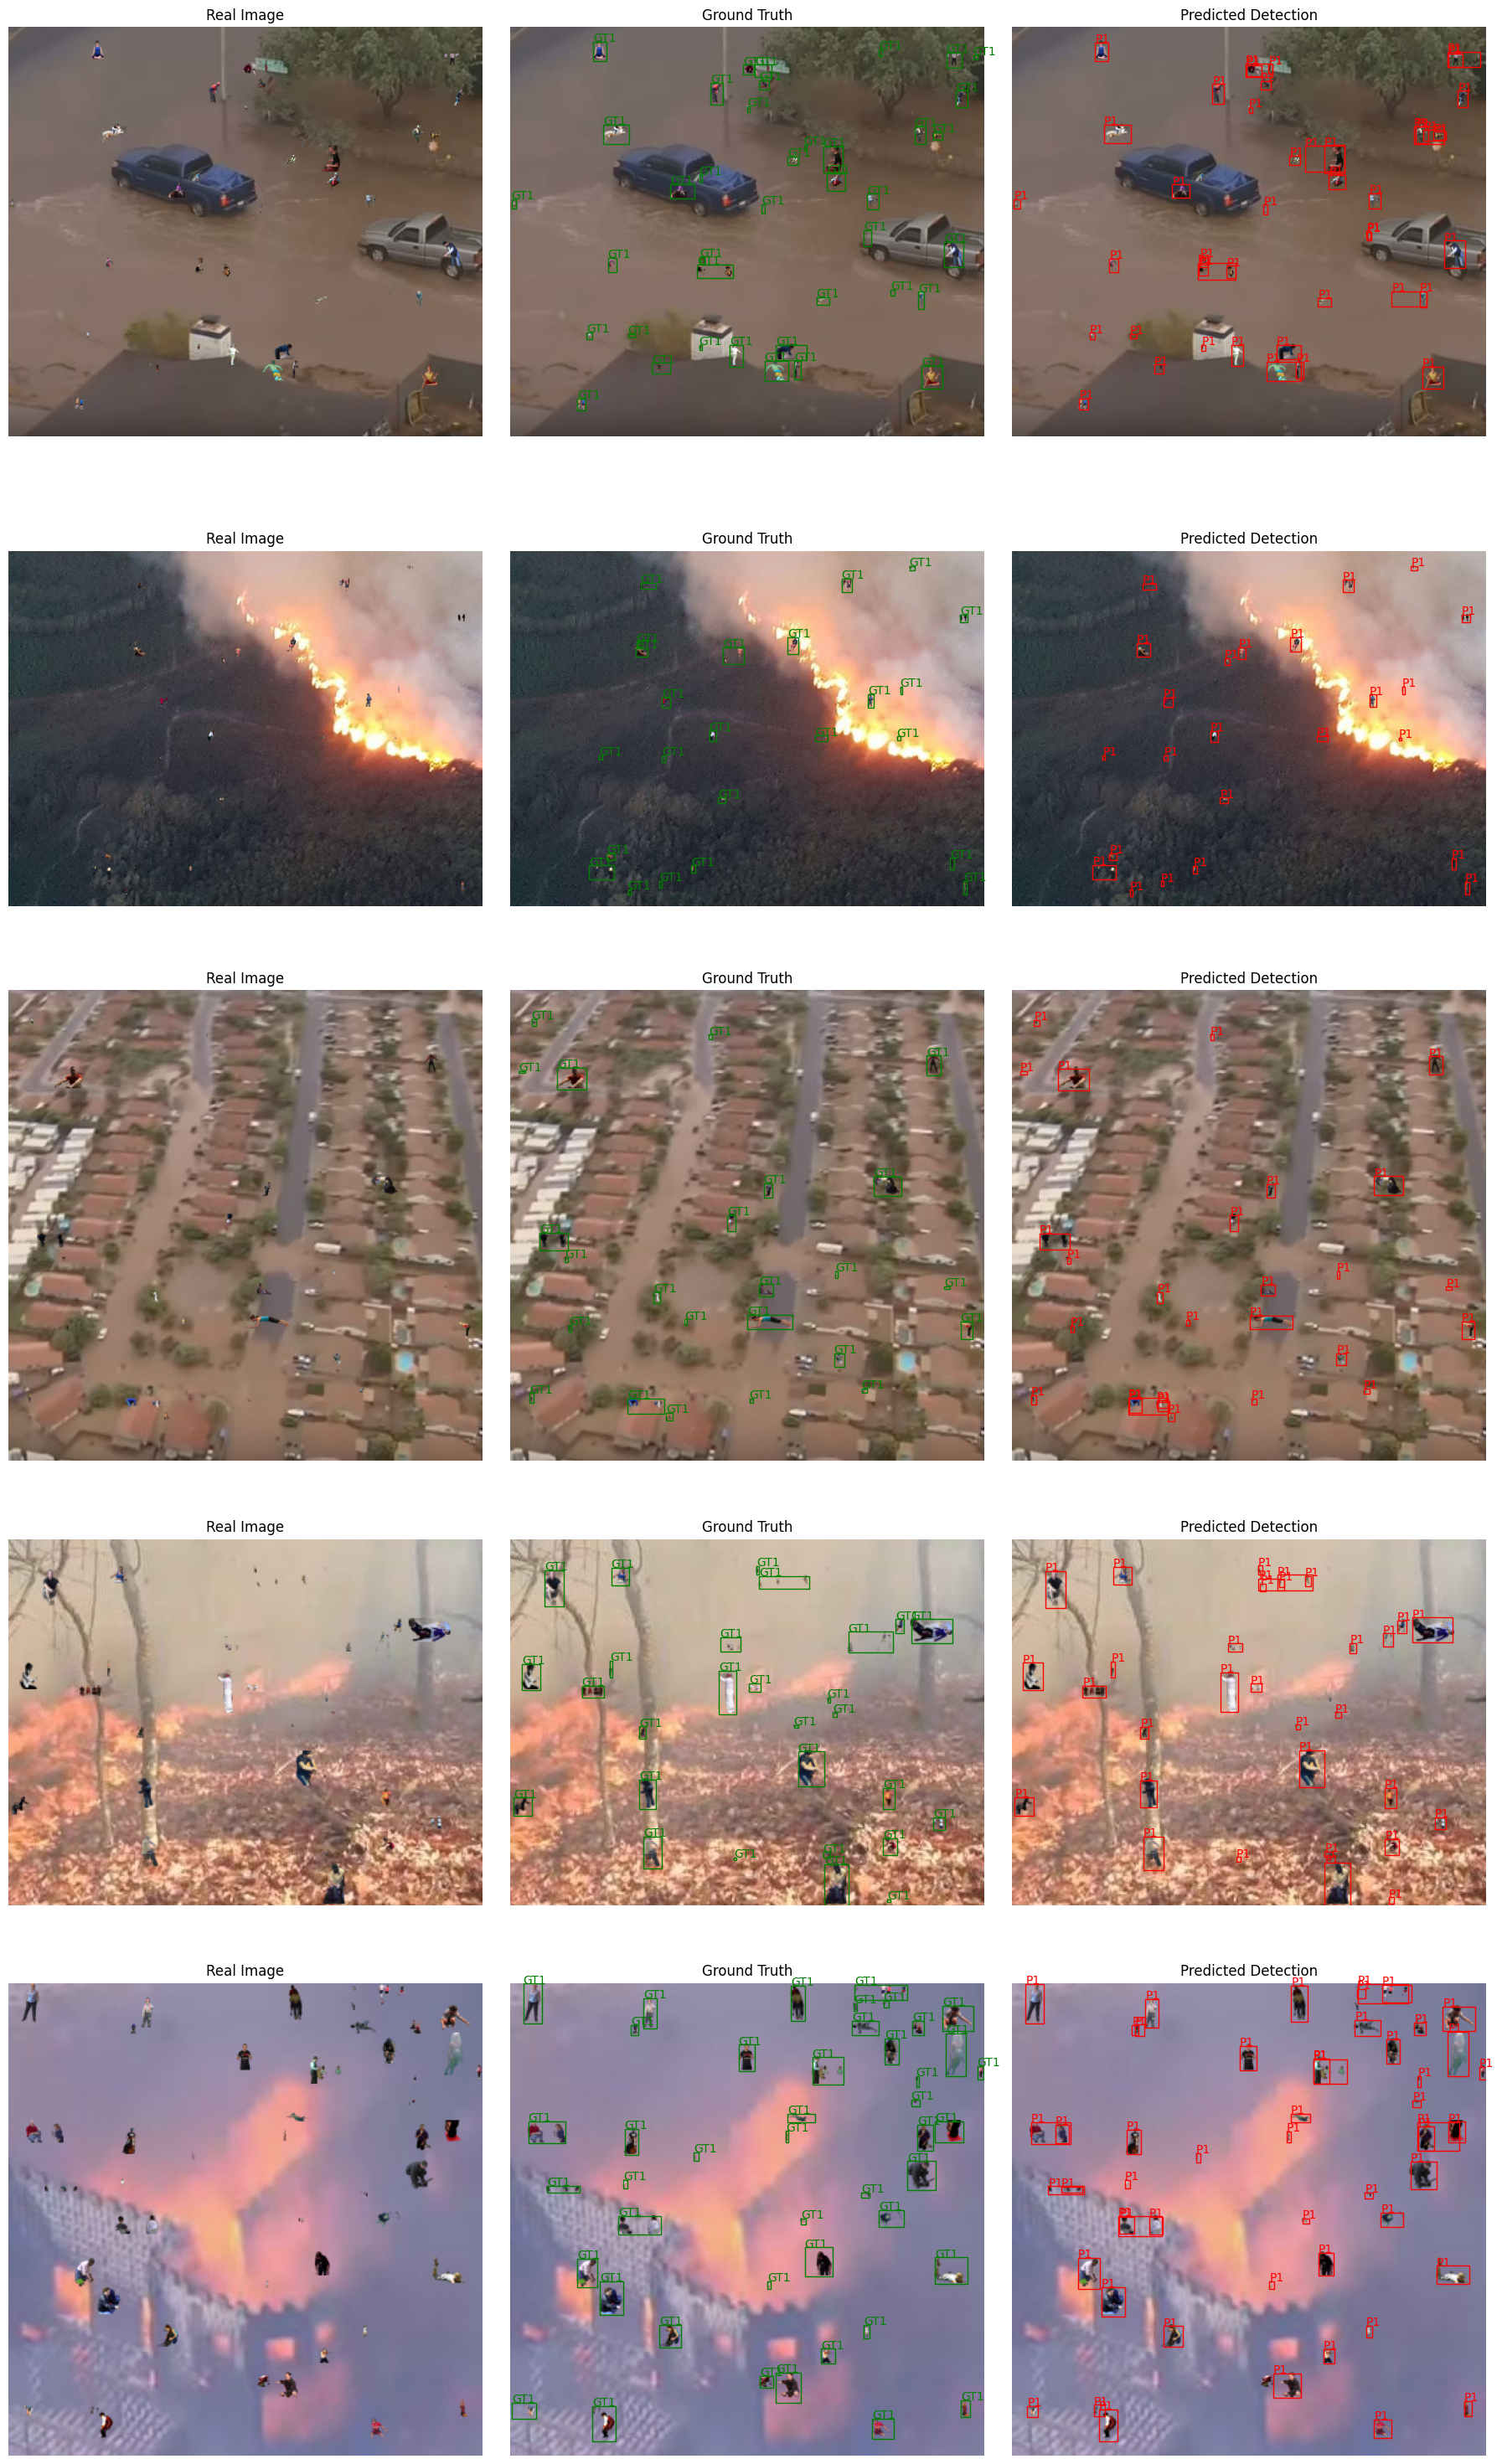

In [7]:
# 7-------------------------------
# Visualization: Display 5 Random Validation Samples
# -------------------------------

import matplotlib.pyplot as plt         # For plotting images and figures.
import matplotlib.patches as patches     # For drawing rectangle patches (bounding boxes).
import numpy as np                       # For numerical operations.

# Set the number of random samples to visualize.
num_vis = 5

# Randomly sample 5 indices from the test_dataset (assumes test_dataset is defined).
indices = random.sample(range(len(test_dataset)), num_vis)

# Create a figure with 5 rows and 3 columns (for 3 panels per sample).
# The figure size is set to 18 inches in width and 6 * num_vis inches in height.
fig, axes = plt.subplots(nrows=num_vis, ncols=3, figsize=(18, 6 * num_vis))

# Define a helper function to draw bounding boxes on an axis.
def draw_boxes(ax, boxes, color, label_prefix):
    for i, box in enumerate(boxes):
        # Unpack the bounding box coordinates.
        x1, y1, x2, y2 = box
        # Calculate the width and height of the box.
        w, h = x2 - x1, y2 - y1
        # Create a rectangle patch with the calculated position and dimensions.
        rect = patches.Rectangle((x1, y1), w, h, linewidth=1, edgecolor=color, facecolor='none')
        ax.add_patch(rect)  # Add the rectangle patch to the axis.
        # Add a text label (e.g., GT1, GT2, etc. for ground truth or P1, P2, etc. for prediction) near the box.
        ax.text(x1, y1, f"{label_prefix}{i+1}", color=color, fontsize=10, backgroundcolor="none")

# Loop over each randomly selected sample index.
for idx_i, idx in enumerate(indices):
    # Get the image and target annotations from the test_dataset.
    image, target = test_dataset[idx]
    
    # -------------------------------
    # Denormalize the image for visualization.
    # -------------------------------
    # The applied transform normalized the image using ImageNet statistics.
    # To visualize, we reverse that normalization.
    image_np = image.clone()  # Clone the tensor to avoid modifying the original.
    # Multiply by the standard deviation and add the mean to reverse normalization.
    image_np = image_np * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1) + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    # Permute the dimensions from (C, H, W) to (H, W, C) for matplotlib.
    image_np = image_np.permute(1, 2, 0).cpu().numpy()
    # Clip the values to ensure they are within the [0, 1] range.
    image_np = np.clip(image_np, 0, 1)
    
    # -------------------------------
    # Panel 1: Display the Real Image.
    # -------------------------------
    ax1 = axes[idx_i, 0]
    ax1.imshow(image_np)
    ax1.set_title("Real Image")
    ax1.axis("off")  # Hide axis ticks and labels.
    
    # -------------------------------
    # Panel 2: Display Ground Truth Bounding Boxes.
    # -------------------------------
    ax2 = axes[idx_i, 1]
    ax2.imshow(image_np)
    ax2.set_title("Ground Truth")
    ax2.axis("off")
    # Loop over each ground truth box and draw it in green.
    for box in target["boxes"]:
        draw_boxes(ax2, [box.cpu().numpy()], "g", "GT")
    
    # -------------------------------
    # Panel 3: Display Predicted Detections.
    # -------------------------------
    ax3 = axes[idx_i, 2]
    ax3.imshow(image_np)
    ax3.set_title("Predicted Detection")
    ax3.axis("off")
    # Run the model on the image to get predictions (move image to the correct device).
    with torch.no_grad():
        pred = model([image.to(device)])[0]
    # Filter predictions to keep only those with scores greater than 0.5.
    keep = pred['scores'] > 0.5
    pred_boxes = pred['boxes'][keep]
    # Loop over each predicted box and draw it in red.
    for box in pred_boxes:
        draw_boxes(ax3, [box.cpu().numpy()], "r", "P")
        
# Adjust the layout so that subplots do not overlap.
plt.tight_layout()
# Display the figure.
plt.show()
